## Library imports

In [ ]:
azure = False
colab = False

if azure or colab:
    !pip install seqeval
    !pip install git+https://www.github.com/keras-team/keras-contrib.git
    !pip install plot_keras_history

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer
from tensorflow.keras import optimizers
from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
from plot_keras_history import plot_history

from prettytable import PrettyTable

In [49]:
print(keras.backend.backend())

tensorflow


In [51]:
# For Google Colab only
if colab:
    !git clone https://github.com/mapriess/GermEval_2014_NER_DEMO.git

## Data: Import

In [52]:
#
# Parser for GermEval 2014 Dataset
#
# Input: Tab-separated file, one token per row, two levels of annotation
# Token    Tag_Level1     Tag_Level2
# 
# Output: Pandas dataframe (columns: Sentence #, Token, TagComb)
#
def parser(path):
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df = pd.read_csv(path, sep='\t', encoding="utf8", quoting=3)

    # Set columns
    cols = ['Sentence #','Word', 'Tag_Level1', 'Tag_Level2']
    df.set_axis(labels=cols, axis='columns', inplace=True)

    # Correct sentence number according to source entries (#)
    # TODO: Find more efficient way to further speed up the parsing
    sent_id = 1
    for index, row in df.iterrows():
        if (row['Sentence #'] == '#'):
            sent_id += 1
            continue
        row['Sentence #'] = "Sentence: " + str(sent_id)

    # Delete rows starting with '#'
    df.drop( df[df['Sentence #'] == '#'].index, inplace=True )

    # Conventional flat named‐entity‐recognition models could be used without any modification once the labels of different levels were joined together into a single level (Agrawal et al. (2022)).
    df['TagComb'] = df['Tag_Level1'] + "+" + df['Tag_Level2']
    df.drop(columns=['Tag_Level1','Tag_Level2'], inplace=True)

    return df

In [53]:
pathColab = ''
if colab:
  pathColab = "GermEval_2014_NER_DEMO/"

df_train = parser(pathColab + "Data/NER-de-train.tsv")
df_val = parser(pathColab + "Data/NER-de-dev.tsv")
df_test = parser(pathColab + "Data/NER-de-test.tsv")
df = parser(pathColab + "Data/NER-de-all.tsv") # TODO: Can also be achieved through concatenation of DFs

## Data: Inspection

In [54]:
print(df_train.shape,df_val.shape,df_test.shape,df.shape)

(452853, 3) (41653, 3) (96499, 3) (591005, 3)


In [55]:
# DF overview
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591005 entries, 0 to 622303
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Sentence #  591005 non-null  object
 1   Word        590999 non-null  object
 2   TagComb     591005 non-null  object
dtypes: object(3)
memory usage: 18.0+ MB
None


<AxesSubplot:>

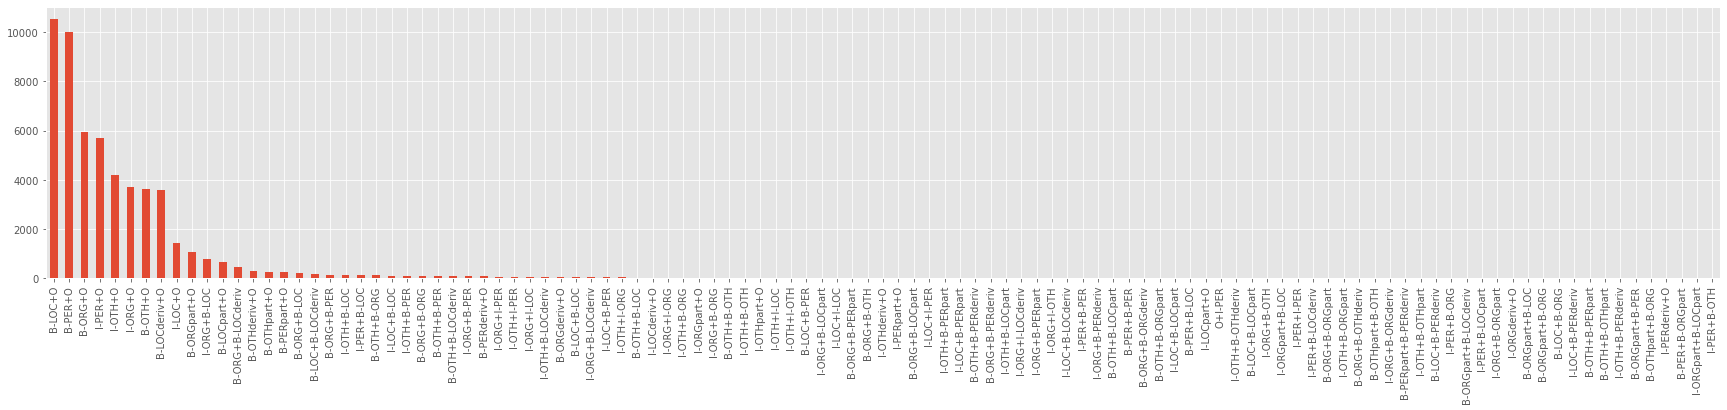

In [56]:
# NER tag distribution
df[df["TagComb"]!="O+O"]["TagComb"].value_counts().plot(kind="bar", figsize=(30,5))

In [57]:
# Occurrence of combined tag "I-OTH+I-LOC"
df[df["TagComb"]=="I-OTH+I-LOC"]

,Sentence #,Word,TagComb
36901,Sentence: 1865,England,I-OTH+I-LOC
69076,Sentence: 3496,Lorenzo,I-OTH+I-LOC
72454,Sentence: 3667,.,I-OTH+I-LOC
72455,Sentence: 3667,Hedwigskirche,I-OTH+I-LOC
222580,Sentence: 11234,Oranienburg,I-OTH+I-LOC
265093,Sentence: 13389,Meeres,I-OTH+I-LOC
337843,Sentence: 17035,Big,I-OTH+I-LOC
337844,Sentence: 17035,Horn,I-OTH+I-LOC
347724,Sentence: 17500,Charlie,I-OTH+I-LOC
356374,Sentence: 17933,Nam,I-OTH+I-LOC


In [58]:
# NER tag distribution
df['TagComb'].value_counts()

O+O                     535985
B-LOC+O                  10522
B-PER+O                  10022
B-ORG+O                   5939
I-PER+O                   5710
                         ...  
B-ORGpart+B-LOCderiv         1
I-OTH+B-OTHpart              1
B-OTHpart+B-OTH              1
B-ORGpart+B-LOC              1
I-PER+B-ORG                  1
Name: TagComb, Length: 110, dtype: int64

In [59]:
# Sentence length distribution
df['Sentence #'].value_counts()

Sentence: 15371    56
Sentence: 5900     52
Sentence: 19927    51
Sentence: 31063    51
Sentence: 22048    50
                   ..
Sentence: 4620      4
Sentence: 9816      4
Sentence: 900       3
Sentence: 16982     3
Sentence: 15419     3
Name: Sentence #, Length: 31300, dtype: int64

In [60]:
# List of unique words
words = list(set(df['Word'].values))
words.append('PADword') # later used for creating input vectors of fixed length (padding)
n_words = len(words)
print("Number of unique words in dataset:", n_words)

Number of unique words in dataset: 89946


In [61]:
# List of unique (combined) tokens
tags = list(set(df["TagComb"].values))
n_tags = len(tags)
print("Number of unique tags in dataset:", n_tags)

Number of unique tags in dataset: 110


In [62]:
# Check null elements
df.isnull().sum(axis = 0)

Sentence #    0
Word          6
TagComb       0
dtype: int64

**Conclusion:**

We have 31300 sentences in our training dataset, 89946 different words and 110 different named entities (Tags).

## Data: Preparation

In [63]:
#
# Input: Pandas dataframe (columns: Sentence #, Token, TagComb)
# Output: list of tuples [(word, named entity tag), ...]
#
def createSentenceList(df):
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["TagComb"].values.tolist())]
    grouped = df.groupby("Sentence #").apply(agg_func)
    sentences = [s for s in grouped] 
    return sentences

In [64]:
sentences_df = createSentenceList(df)
sentences_df_train = createSentenceList(df_train)
sentences_df_val = createSentenceList(df_val)
sentences_df_test = createSentenceList(df_test)

print("# sentences complete dataset: ", len(sentences_df))
print("# sentences train dataset: ", len(sentences_df_train))
print("# sentences val dataset: ", len(sentences_df_val))
print("# sentences test dataset: ", len(sentences_df_test))

# sentences complete dataset:  31300
# sentences train dataset:  24000
# sentences val dataset:  2200
# sentences test dataset:  5100


In [65]:
# Get first sentence
print( "Train: " + str(sentences_df_train[0]) + "\n" )
print( "Val: " + str(sentences_df_val[0]) + "\n" )
print( "Test: " + str(sentences_df_test[0]))

Train: [('Schartau', 'B-PER+O'), ('sagte', 'O+O'), ('dem', 'O+O'), ('"', 'O+O'), ('Tagesspiegel', 'B-ORG+O'), ('"', 'O+O'), ('vom', 'O+O'), ('Freitag', 'O+O'), (',', 'O+O'), ('Fischer', 'B-PER+O'), ('sei', 'O+O'), ('"', 'O+O'), ('in', 'O+O'), ('einer', 'O+O'), ('Weise', 'O+O'), ('aufgetreten', 'O+O'), (',', 'O+O'), ('die', 'O+O'), ('alles', 'O+O'), ('andere', 'O+O'), ('als', 'O+O'), ('überzeugend', 'O+O'), ('war', 'O+O'), ('"', 'O+O'), ('.', 'O+O')]

Val: [('Gleich', 'O+O'), ('darauf', 'O+O'), ('entwirft', 'O+O'), ('er', 'O+O'), ('seine', 'O+O'), ('Selbstdarstellung', 'O+O'), ('"', 'O+O'), ('Ecce', 'B-OTH+O'), ('homo', 'I-OTH+O'), ('"', 'O+O'), ('in', 'O+O'), ('enger', 'O+O'), ('Auseinandersetzung', 'O+O'), ('mit', 'O+O'), ('diesem', 'O+O'), ('Bild', 'O+O'), ('Jesu', 'B-PER+O'), ('.', 'O+O')]

Test: [('1951', 'O+O'), ('bis', 'O+O'), ('1953', 'O+O'), ('wurde', 'O+O'), ('der', 'O+O'), ('nördliche', 'O+O'), ('Teil', 'O+O'), ('als', 'O+O'), ('Jugendburg', 'O+O'), ('des', 'O+O'), ('Kolpingw

In [66]:
# Determine largest sentence
largest_sen = max(len(sen) for sen in sentences_df)
print('Biggest sentence has {} words'.format(largest_sen))

Biggest sentence has 56 words


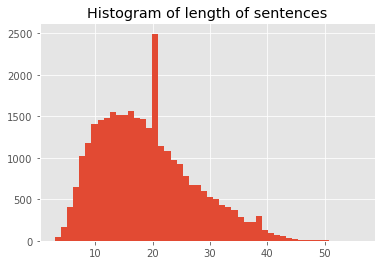

In [67]:
# Histogram of length of sentences
%matplotlib inline
plt.hist([len(sen) for sen in sentences_df], bins= 50)
plt.title("Histogram of length of sentences")
plt.show()

**Conclusion:**

The longest sentence has 56 words in it and we can see that almost all of the sentences have less than 50 words in them.

In [68]:
# Assigning index to all unique words and tags
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}

# Print index for exemplary word and tag
print(words2index['Tagesspiegel'])
print(tags2index['B-LOC+B-PER'])

77166
94


In [69]:
# Visualise words to index and vice versa mappings
df['Word_idx'] = df['Word'].map(words2index)
df['Tag_idx'] = df['TagComb'].map(tags2index)
df.head()

,Sentence #,Word,TagComb,Word_idx,Tag_idx
0,Sentence: 1,Schartau,B-PER+O,43658,67
1,Sentence: 1,sagte,O+O,6959,78
2,Sentence: 1,dem,O+O,23949,78
3,Sentence: 1,"""",O+O,565,78
4,Sentence: 1,Tagesspiegel,B-ORG+O,77166,69


### Apply simple index embedding of shape (#sent, max_len) for x values

In [70]:
# Convert words to indices defining input vector x of shape (#sent, max_len) with max_len = 50 in this case
# Here, the index of words are used as embeddings and afterwards the keras embedding layer to create dense vector representations
max_len = 50

X_tr = [[words2index[w[0]] for w in s] for s in sentences_df_train]
X_val = [[words2index[w[0]] for w in s] for s in sentences_df_val]
X_te = [[words2index[w[0]] for w in s] for s in sentences_df_test]

# Padding sentences to make the length of all sentences same
X_tr = pad_sequences(maxlen=max_len, sequences=X_tr, padding="post", value=0)
X_val = pad_sequences(maxlen=max_len, sequences=X_val, padding="post", value=0)
X_te = pad_sequences(maxlen=max_len, sequences=X_te, padding="post", value=0)

# Check first data samples
print("Shapes: " + str(X_tr.shape) + ", " + str(X_val.shape) + ", " + str(X_te.shape))
print("Train: " + str(X_tr[0]) + "\n")
print("Val: " + str(X_val[0]) + "\n")
print("Test: " + str(X_te[0]))

Shapes: (24000, 50), (2200, 50), (5100, 50)
Train: [43658  6959 23949   565 77166   565  6855 69883 58082 23012  9013   565
 40347 22360 11853 36201 58082 58193  2412 60338 50930 42633 68334   565
  9683     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]

Val: [49304 45542 27486 26802 84972 57892   565 63844 44890   565 40347 21329
  9529 19971 34091  6277 18909  9683     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]

Test: [89938 67001 58663 87787 18719 83195 74601 50930 29569 55122 60286 69275
  9683     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


### Apply index embeddings (+ categorical transformation) of shape (#sent, max_len, #tags) for y values

In [82]:
# Convert tags to indices defining input vector y of shape (#sent, max_len, #tags) with max_len = 50 in this case
y_tr = [[tags2index[w[1]] for w in s] for s in sentences_df_train]
y_val = [[tags2index[w[1]] for w in s] for s in sentences_df_val]
y_te = [[tags2index[w[1]] for w in s] for s in sentences_df_test]

# Padding tags to match length of sentence
y_tr = pad_sequences(maxlen=max_len, sequences=y_tr, padding="post", value=tags2index["O+O"])
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=tags2index["O+O"])
y_te = pad_sequences(maxlen=max_len, sequences=y_te, padding="post", value=tags2index["O+O"])

# Make y categorical (#sentences, max_len, #tags)
y_tr = [to_categorical(i, num_classes=n_tags) for i in y_tr]
y_val = [to_categorical(i, num_classes=n_tags) for i in y_val]
y_te = [to_categorical(i, num_classes=n_tags) for i in y_te]

# Check first data samples
print("Train: " + str(y_tr[0]) + "\n")
print("Val: " + str(y_val[0]) + "\n")
print("Test: " + str(y_te[0]))

Train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Val: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Test: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model: Defining architecture

In [30]:
MAX_SENTENCE    = max_len
TAG_COUNT       = n_tags
WORD_COUNT      = n_words + 1 # size of the vocabulary
DENSE_EMBEDDING = 50
LSTM_UNITS      = 50
LSTM_DROPOUT    = 0.1
DENSE_UNITS     = 50

tf.compat.v1.set_random_seed(32)

# Using keras Model approach
# input = Input(shape=(MAX_SENTENCE,))
# model = Embedding(input_dim=WORD_COUNT, output_dim=DENSE_EMBEDDING, input_length=MAX_SENTENCE)(input)
# model = Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, recurrent_dropout=LSTM_DROPOUT))(model)
# out = TimeDistributed(Dense(TAG_COUNT, activation="softmax"))(model)
# model = Model(input, out)

# Using keras Sequential approach
model = keras.Sequential()
model.add(InputLayer(input_shape=(X_tr[0].shape)))
model.add(Embedding(input_dim=WORD_COUNT, output_dim=DENSE_EMBEDDING, input_length=MAX_SENTENCE))
model.add(Bidirectional(LSTM(units=LSTM_UNITS, return_sequences=True, recurrent_dropout=LSTM_DROPOUT)))
model.add(TimeDistributed(Dense(TAG_COUNT, activation="softmax")))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
opt = optimizers.Adam(lr=0.001)
# opt = optimizers.RMSprop(lr=0.001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            4497350   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 100)           40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 110)           11110     
Total params: 4,548,860
Trainable params: 4,548,860
Non-trainable params: 0
_________________________________________________________________


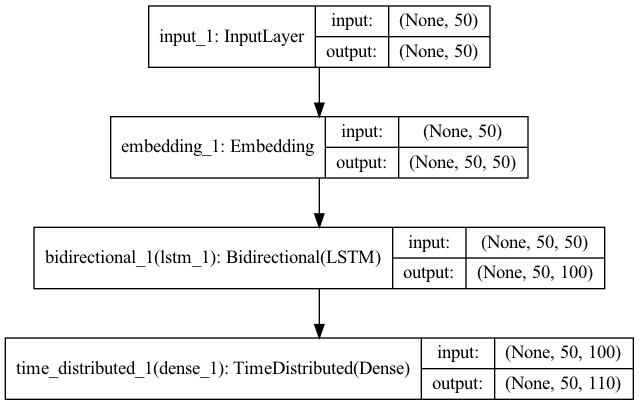

In [36]:
plot_model(model,'model.png',show_shapes= True)

## Model: Training + Validation

In [37]:
BATCH_SIZE = 32
EPOCHS = 5

history = model.fit(X_tr, np.array(y_tr), validation_data=(X_val, np.array(y_val)), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 24000 samples, validate on 2200 samples
Epoch 1/5
24000/24000 [==============================] - 73s 3ms/step - loss: 0.3214 - accuracy: 0.9631 - val_loss: 0.1484 - val_accuracy: 0.9655
Epoch 2/5
24000/24000 [==============================] - 71s 3ms/step - loss: 0.1153 - accuracy: 0.9705 - val_loss: 0.1231 - val_accuracy: 0.9709
Epoch 3/5
24000/24000 [==============================] - 67s 3ms/step - loss: 0.0795 - accuracy: 0.9792 - val_loss: 0.1105 - val_accuracy: 0.9754
Epoch 4/5
24000/24000 [==============================] - 72s 3ms/step - loss: 0.0555 - accuracy: 0.9862 - val_loss: 0.1090 - val_accuracy: 0.9768
Epoch 5/5
24000/24000 [==============================] - 69s 3ms/step - loss: 0.0374 - accuracy: 0.9908 - val_loss: 0.1074 - val_accuracy: 0.9777


In [38]:
hist = pd.DataFrame(history.history)
hist

,val_loss,val_accuracy,loss,accuracy
0,0.148357,0.965518,0.321401,0.963148
1,0.123064,0.970873,0.115254,0.970463
2,0.110482,0.975364,0.079514,0.979235
3,0.108983,0.976827,0.055505,0.986178
4,0.107384,0.977655,0.037351,0.990758


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

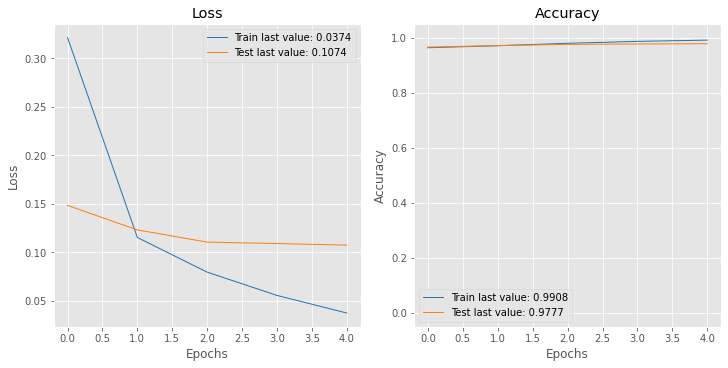

In [39]:
plot_history(history.history)

## Model: Prediction for test data

In [40]:
# Predict output for test data
test_pred = model.predict(X_te, verbose=1)
# Index as key and tag as value
idx2tag = {i: w for w, i in tags2index.items()}
# Function to convert indexed tags to corresponding actual tags
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

5100/5100 [==============================] - 2s 410us/step


In [41]:
print("Accuracy: ", accuracy_score(test_labels, pred_labels))

Accuracy:  0.9775843137254902


In [42]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

/Applications/anaconda3/envs/tf1/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+O seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Applications/anaconda3/envs/tf1/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O+I-PER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


F1-score: 49.8%


In [43]:
print(classification_report(test_labels, pred_labels))

/Applications/anaconda3/envs/tf1/lib/python3.7/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

         LOC+B-LOC       0.00      0.00      0.00        31
    LOC+B-LOCderiv       0.00      0.00      0.00        42
         LOC+B-PER       0.00      0.00      0.00        15
    LOC+B-PERderiv       0.00      0.00      0.00         1
     LOC+B-PERpart       0.00      0.00      0.00         1
         LOC+I-LOC       0.00      0.00      0.00         2
             LOC+O       0.73      0.51      0.60      1710
        LOCderiv+O       0.81      0.71      0.76       561
         LOCpart+O       0.00      0.00      0.00       109
         ORG+B-LOC       0.53      0.31      0.39       140
    ORG+B-LOCderiv       0.60      0.48      0.53        81
     ORG+B-LOCpart       0.00      0.00      0.00         4
         ORG+B-ORG       0.00      0.00      0.00        10
    ORG+B-ORGderiv       0.00      0.00      0.00         1
         ORG+B-PER       0.00      0.00      0.00        24
    ORG+B-PERderiv       0.00      0.00

## Model: Output for random test input

In [44]:
i = 40
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
    
x = PrettyTable()
x.field_names = ["Word", "Actual Tag", "Predicted Tag"]

for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        # x.add_row([words[w-1], tags[t], tags[pred]])
        x.add_row([words[w], tags[t], tags[pred]])
        
print(x)

+----------------------+-------------+---------------+
|         Word         |  Actual Tag | Predicted Tag |
+----------------------+-------------+---------------+
|         Sie          |     O+O     |      O+O      |
|      überzeugte      |     O+O     |      O+O      |
|         als          |     O+O     |      O+O      |
|  Psychiatrie-Ärztin  |     O+O     |      O+O      |
|          Dr          |     O+O     |      O+O      |
|          .           |     O+O     |      O+O      |
|      Hildegard       |   B-PER+O   |    B-PER+O    |
|      Heinemann       |   I-PER+O   |    I-PER+O    |
|          im          |     O+O     |      O+O      |
|         Rolf         | B-PERpart+O |    B-PER+O    |
|    Hochhuth-Stück    | I-PERpart+O |    I-PER+O    |
|         Heil         |   B-OTH+O   |    I-PER+O    |
|        Hitler        | I-OTH+B-PER |    I-PER+O    |
|        unter         |     O+O     |      O+O      |
|         der          |     O+O     |      O+O      |
|        R

## Visualising in spacy

In [117]:
sen = ''
for s in sentences_df_test[40]:
  sen += s[0] + ' '
sen

'Sie überzeugte als Psychiatrie-Ärztin Dr . Hildegard Heinemann im Rolf Hochhuth-Stück Heil Hitler unter der Regie von Lutz Blochberger im Akademie Theater in Berlin und als Maria/Maschinenmaria in METROPOLIS am Schauspielhaus Zürich . '

In [118]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')
text = nlp(sen)
displacy.render(text, style = 'ent', jupyter=True)

## Model: Test arbitrary query sentence not part of test data

In [45]:
test_sentence = ["Berlin", "ist", "die", "Hauptstadt", "von", "Deutschland", "und", "Bayern", "München", "ist", "ein", "deutscher", "Fußballclub"]

In [46]:
x_test_sent = pad_sequences(sequences=[[words2index.get(w, 0) for w in test_sentence]], padding="post", value=0, maxlen=max_len)

In [47]:
# Output tags for query input
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)

x = PrettyTable()
x.field_names = ["Word", "Predicted Tag"]

for w, pred in zip(test_sentence, p[0]):
    x.add_row([w, tags[pred]])
        
print(x)

+-------------+---------------+
|     Word    | Predicted Tag |
+-------------+---------------+
|    Berlin   |    B-LOC+O    |
|     ist     |      O+O      |
|     die     |      O+O      |
|  Hauptstadt |      O+O      |
|     von     |      O+O      |
| Deutschland |    B-LOC+O    |
|     und     |      O+O      |
|    Bayern   |    B-LOC+O    |
|   München   |    B-LOC+O    |
|     ist     |      O+O      |
|     ein     |      O+O      |
|  deutscher  |  B-LOCderiv+O |
| Fußballclub |      O+O      |
+-------------+---------------+
